# Классификация токсичных комментариев 💬

## Введение

В этом ноутбуке мы познакомимся с задачей **классификации текста** - одной из важнейших задач обработки естественного языка (NLP). 

**Наша задача:** по тексту комментария определить, является ли он токсичным (содержит оскорбления, грубости) или нет.

**Что мы изучим:**
- Предобработка текста: нормализация, токенизация
- Удаление стоп-слов
- Лемматизация и стемминг
- Векторизация текста: Bag of Words и TF-IDF
- Классификация с помощью логистической регрессии
- Анализ весов модели


## 1. Импорт библиотек


In [1]:
# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Библиотеки для обработки текста
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# для обработки текста
import re

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Все библиотеки успешно загружены!")


✅ Все библиотеки успешно загружены!


In [2]:
# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

## 2. Загрузка данных


Датасет содержит комментарии из Wikipedia. Каждый комментарий размечен как токсичный (1) или нетоксичный (0).

**Признаки:**
- `comment_text` - текст комментария
- `is_toxic` - метка класса (0 или 1)

**Скачаем датасет:**


In [ ]:
# Скачиваем датасет с Google Drive
!gdown "https://drive.google.com/uc?id=1a-O_gckKyVRQPF5RhBxo-RnZBEGpezE0"
!unzip -q data_toxic.zip


In [4]:
# Загружаем обучающую выборку
df_full = pd.read_csv('toxic_train.csv')
df_full.drop(columns='Unnamed: 0', inplace=True)

# Создаем валидационную выборку (20%)
df_val = df_full.sample(frac=0.2, random_state=42)
df_train = df_full.drop(df_val.index)

# Загружаем тестовую выборку
df_test = pd.read_csv('toxic_test.csv')
df_test.drop(columns='Unnamed: 0', inplace=True)

print(f"Размер обучающей выборки: {df_train.shape[0]} комментариев")
print(f"Размер валидационной выборки: {df_val.shape[0]} комментариев")
print(f"Размер тестовой выборки: {df_test.shape[0]} комментариев")

# Посмотрим на первые строки
print("\nПервые строки датасета:")
df_train.head()


Размер обучающей выборки: 41649 комментариев
Размер валидационной выборки: 10412 комментариев
Размер тестовой выборки: 20676 комментариев

Первые строки датасета:


,comment_text,is_toxic
0,Explanation\nWhy the edits made under my usern...,False
1,D'aww! He matches this background colour I'm s...,False
2,"Hey man, I'm really not trying to edit war. It...",False
3,"""\nMore\nI can't make any real suggestions on ...",False
5,"""\n\nCongratulations from me as well, use the ...",False


## 3. Разведочный анализ данных (EDA)


### 3.1 Распределение классов

Проверим, сбалансирован ли наш датасет:


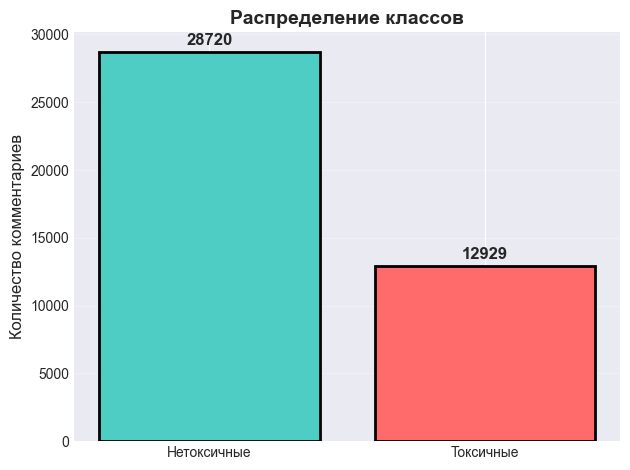


Нетоксичных комментариев: 28720 (69.0%)
Токсичных комментариев: 12929 (31.0%)


In [5]:
# Подсчитаем количество токсичных и нетоксичных комментариев
class_counts = df_train['is_toxic'].value_counts()

# Bar plot
plt.bar(['Нетоксичные', 'Токсичные'], 
            [class_counts[0], class_counts[1]], 
            color=['#4ECDC4', '#FF6B6B'],
            edgecolor='black',
            linewidth=2)
plt.ylabel('Количество комментариев', fontsize=12)
plt.title('Распределение классов', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate([class_counts[0], class_counts[1]]):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold', fontsize=12)


plt.tight_layout()
plt.show()

print(f"\nНетоксичных комментариев: {class_counts[0]} ({class_counts[0]/len(df_train)*100:.1f}%)")
print(f"Токсичных комментариев: {class_counts[1]} ({class_counts[1]/len(df_train)*100:.1f}%)")


### 3.2 Примеры комментариев

Посмотрим на примеры токсичных и нетоксичных комментариев:


In [6]:
print("📝 Примеры НЕТОКСИЧНЫХ комментариев:")
print("=" * 80)
for i, text in enumerate(df_train[df_train['is_toxic'] == 0]['comment_text'].head(3).values, 1):
    txt = f"{i}. {text[:200]}..." if len(text) > 200 else f"{i}. {text}"
    print(textwrap.fill(txt, width=40))
    print()

print("\n💢 Примеры ТОКСИЧНЫХ комментариев:")
print("=" * 80)
for i, text in enumerate(df_train[df_train['is_toxic'] == 1]['comment_text'].head(3).values, 1):
    txt = f"{i}. {text[:200]}..." if len(text) > 200 else f"{i}. {text}"
    print(textwrap.fill(txt, width=40))
    print()


📝 Примеры НЕТОКСИЧНЫХ комментариев:
1. Explanation Why the edits made under
my username Hardcore Metallica Fan were
reverted? They weren't vandalisms, just
closure on some GAs after I voted at New
York Dolls FAC. And please don't remove
th...

2. D'aww! He matches this background
colour I'm seemingly stuck with. Thanks.
(talk) 21:51, January 11, 2016 (UTC)

3. Hey man, I'm really not trying to
edit war. It's just that this guy is
constantly removing relevant information
and talking to me through edits instead
of my talk page. He seems to care more
about the...


💢 Примеры ТОКСИЧНЫХ комментариев:
1. Hey... what is it.. @ | talk . What
is it... an exclusive group of some WP
TALIBANS...who are good at destroying,
self-appointed purist who GANG UP any
one who asks them questions abt their
ANTI-SOCIA...

2. Bye!   Don't look, come or think of
comming back! Tosser.

3. You are gay or antisemmitian?
Archangel WHite Tiger  Meow!
Greetingshhh!  Uh, there are two ways,
why you do erased my comme

### 3.3 Длина комментариев

Посмотрим, отличаются ли токсичные комментарии по длине:


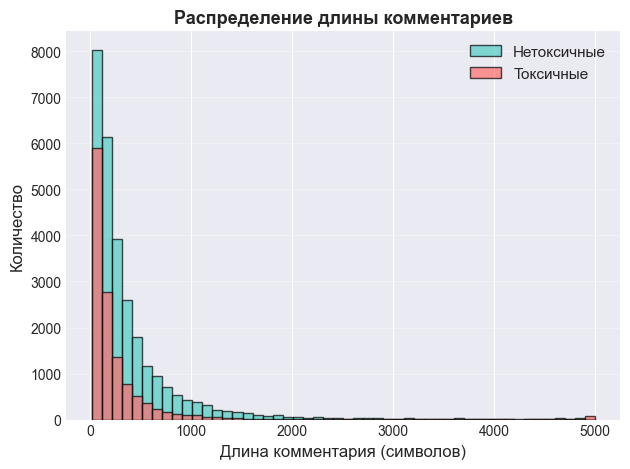

Средняя длина нетоксичных комментариев: 406.3 символов
Средняя длина токсичных комментариев: 303.2 символов


In [7]:
# Вычисляем длину комментариев
df_train['comment_length'] = df_train['comment_text'].str.len()


# Гистограммы
plt.hist(df_train[df_train['is_toxic'] == 0]['comment_length'], 
             bins=50, alpha=0.7, label='Нетоксичные', color='#4ECDC4', edgecolor='black')
plt.hist(df_train[df_train['is_toxic'] == 1]['comment_length'], 
             bins=50, alpha=0.7, label='Токсичные', color='#FF6B6B', edgecolor='black')
plt.xlabel('Длина комментария (символов)', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.title('Распределение длины комментариев', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Средняя длина нетоксичных комментариев: {df_train[df_train['is_toxic']==0]['comment_length'].mean():.1f} символов")
print(f"Средняя длина токсичных комментариев: {df_train[df_train['is_toxic']==1]['comment_length'].mean():.1f} символов")


## 4. Предобработка текста

Текст нельзя напрямую подать на вход модели машинного обучения. Сначала нужно его обработать!

**Основной метод предобработки - нормализация:**
- Приведение к нижнему регистру ("Hello" → "hello")
- Удаление специальных символов и знаков препинания
- Удаление лишних пробелов

**Зачем?** Чтобы слова "Hello", "hello" и "HELLO" воспринимались как одно и то же слово.


### 4.1 Функция нормализации


In [8]:
def normalize_text(text):
    """
    Нормализация текста:
    1. Приведение к нижнему регистру
    2. Замена всех не-буквенно-цифровых символов на пробелы
    3. Удаление множественных пробелов
    """
    # Приводим к нижнему регистру
    text = text.lower()
    
    # Заменяем все символы, кроме букв и цифр, на пробелы
    text = re.sub(r'[^a-z0-9]', ' ', text)
    
    # Удаляем множественные пробелы
    text = re.sub(r'\s+', ' ', text)
    
    # Удаляем пробелы в начале и конце
    text = text.strip()
    
    return text


In [9]:
# Пример нормализации
example_text = df_train['comment_text'].iloc[10][:100]
normalized_text = normalize_text(example_text)

print("📄 ОРИГИНАЛЬНЫЙ ТЕКСТ:")
print(textwrap.fill(example_text, width=40))
print("\n📝 НОРМАЛИЗОВАННЫЙ ТЕКСТ:")
print(textwrap.fill(normalized_text, width=40))


📄 ОРИГИНАЛЬНЫЙ ТЕКСТ:
Before you start throwing accusations
and warnings at me, lets review the edit
itself-making ad homi

📝 НОРМАЛИЗОВАННЫЙ ТЕКСТ:
before you start throwing accusations
and warnings at me lets review the edit
itself making ad homi


In [10]:
# Применяем нормализацию ко всем данным
df_train['text'] = df_train['comment_text'].apply(normalize_text)
df_val['text'] = df_val['comment_text'].apply(normalize_text)
df_test['text'] = df_test['comment_text'].apply(normalize_text)

print("✅ Нормализация завершена!")
txt = textwrap.fill(df_train['text'].iloc[0][:100], width=80)
print(f"Пример: '{txt}...'")


✅ Нормализация завершена!
Пример: 'explanation why the edits made under my username hardcore metallica fan were
reverted they weren t v...'


## 5. Векторизация текста

Модели машинного обучения работают с числами, а не с текстом. Нужно превратить текст в числовые векторы!


### 5.1 Bag of Words (CountVectorizer)

**Bag of Words** (мешок слов) - самый простой способ векторизации:
1. Создаем словарь всех уникальных слов
2. Для каждого документа считаем, сколько раз встретилось каждое слово

**Пример:**
- Документ 1: "I love cats"
- Документ 2: "I love dogs"
- Словарь: ["I", "love", "cats", "dogs"]
- Вектор 1: [1, 1, 1, 0]
- Вектор 2: [1, 1, 0, 1]


In [11]:
# Простой пример CountVectorizer
simple_texts = [
    "I love machine learning",
    "I love deep learning",
    "Machine learning is awesome"
]

simple_vectorizer = CountVectorizer()
simple_vectors = simple_vectorizer.fit_transform(simple_texts)

# Показываем словарь
print("📚 Словарь (vocabulary):")
print(simple_vectorizer.get_feature_names_out())

# Показываем векторы
print("\n📊 Векторы (матрица):")
print(simple_vectors.toarray())

# Создаем красивую таблицу
df_example = pd.DataFrame(
    simple_vectors.toarray(),
    columns=simple_vectorizer.get_feature_names_out(),
    index=[f"Doc {i+1}" for i in range(len(simple_texts))]
)
print("\n📋 В виде таблицы:")
print(df_example)


📚 Словарь (vocabulary):
['awesome' 'deep' 'is' 'learning' 'love' 'machine']

📊 Векторы (матрица):
[[0 0 0 1 1 1]
 [0 1 0 1 1 0]
 [1 0 1 1 0 1]]

📋 В виде таблицы:
       awesome  deep  is  learning  love  machine
Doc 1        0     0   0         1     1        1
Doc 2        0     1   0         1     1        0
Doc 3        1     0   1         1     0        1


In [12]:
# Применяем CountVectorizer к нашим данным
# Используем min_df=0.0001 чтобы отфильтровать очень редкие слова
count_vectorizer = CountVectorizer(min_df=0.0001)

# Обучаем на обучающей выборке (вариант 2: без стоп-слов)
X_train_count = count_vectorizer.fit_transform(df_train['text'])
X_val_count = count_vectorizer.transform(df_val['text'])
X_test_count = count_vectorizer.transform(df_test['text'])

print("✅ CountVectorizer создан!")
print(f"Размер словаря: {len(count_vectorizer.get_feature_names_out())} слов")
print(f"Форма матрицы обучающей выборки: {X_train_count.shape}")
print(f"  - {X_train_count.shape[0]} документов")
print(f"  - {X_train_count.shape[1]} признаков (слов)")


✅ CountVectorizer создан!
Размер словаря: 15948 слов
Форма матрицы обучающей выборки: (41649, 15948)
  - 41649 документов
  - 15948 признаков (слов)


## 6. Обучение модели

Будем использовать **логистическую регрессию** - линейный классификатор!


In [13]:
# Подготавливаем метки классов
y_train = df_train['is_toxic'].values
y_val = df_val['is_toxic'].values
y_test = df_test['is_toxic'].values

# Создаем и обучаем модель
model_count = LogisticRegression(max_iter=1000, random_state=42)
model_count.fit(X_train_count, y_train)

# Делаем предсказания
y_pred_count = model_count.predict(X_val_count)

# Оцениваем качество
accuracy_count = accuracy_score(y_val, y_pred_count)

print("📊 Результаты модели (CountVectorizer):")
print(f"Точность на валидации: {accuracy_count:.4f} ({accuracy_count*100:.2f}%)")
print(f"\nПравильно классифицировано: {int(accuracy_count * len(y_val))} из {len(y_val)} комментариев")


📊 Результаты модели (CountVectorizer):
Точность на валидации: 0.9157 (91.57%)

Правильно классифицировано: 9534 из 10412 комментариев


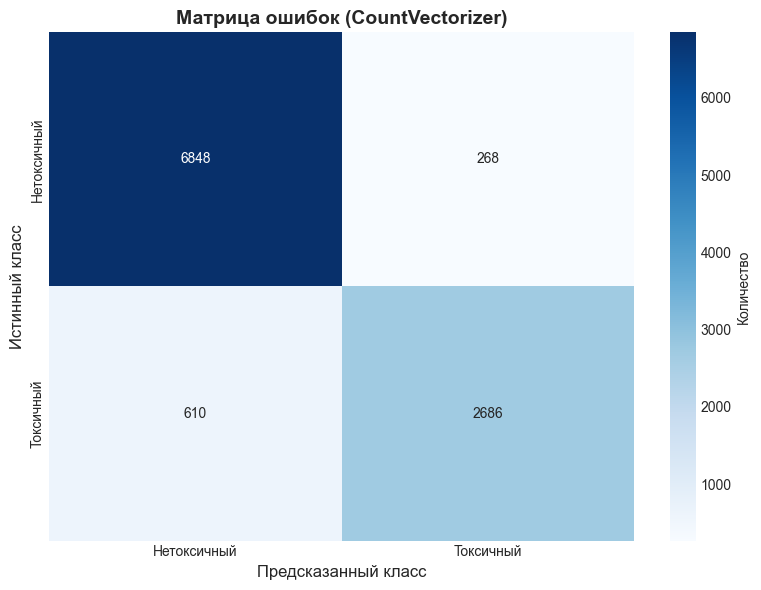


Детальный отчет:
              precision    recall  f1-score   support

 Нетоксичный       0.92      0.96      0.94      7116
   Токсичный       0.91      0.81      0.86      3296

    accuracy                           0.92     10412
   macro avg       0.91      0.89      0.90     10412
weighted avg       0.92      0.92      0.91     10412



In [14]:
# Матрица ошибок
cm = confusion_matrix(y_val, y_pred_count)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Нетоксичный', 'Токсичный'],
            yticklabels=['Нетоксичный', 'Токсичный'],
            cbar_kws={'label': 'Количество'})
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Истинный класс', fontsize=12)
plt.title('Матрица ошибок (CountVectorizer)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nДетальный отчет:")
print(classification_report(y_val, y_pred_count, target_names=['Нетоксичный', 'Токсичный']))


### 6.4 Примеры предсказаний

Посмотрим, как наша модель классифицирует конкретные комментарии:


In [15]:
# Получаем предсказания на валидационной выборке
X_val_best = count_vectorizer.transform(df_val["text"])
y_pred_best = model_count.predict(X_val_best)
y_proba_best = model_count.predict_proba(X_val_best)[:, 1]

# Добавляем предсказания в датафрейм
df_val_copy = df_val.copy()
df_val_copy['predicted'] = y_pred_best
df_val_copy['probability'] = y_proba_best

# Правильные предсказания
print("✅ ПРАВИЛЬНО КЛАССИФИЦИРОВАННЫЕ КОММЕНТАРИИ:\n")
correct = df_val_copy[df_val_copy['is_toxic'] == df_val_copy['predicted']].sample(min(3, len(df_val_copy[df_val_copy['is_toxic'] == df_val_copy['predicted']])), random_state=42)
for idx, row in correct.iterrows():
    label = "ТОКСИЧНЫЙ" if row['is_toxic'] == 1 else "НЕТОКСИЧНЫЙ"
    print(f"Истинная метка: {label}")
    print(f"Предсказание: {label} (вероятность: {row['probability']:.3f})")
    print(f"Текст: {row['comment_text'][:150]}...")
    print("-" * 80)

# Неправильные предсказания
print("\n❌ НЕПРАВИЛЬНО КЛАССИФИЦИРОВАННЫЕ КОММЕНТАРИИ:\n")
incorrect = df_val_copy[df_val_copy['is_toxic'] != df_val_copy['predicted']].sample(min(3, len(df_val_copy[df_val_copy['is_toxic'] != df_val_copy['predicted']])), random_state=42)
for idx, row in incorrect.iterrows():
    true_label = "ТОКСИЧНЫЙ" if row['is_toxic'] == 1 else "НЕТОКСИЧНЫЙ"
    pred_label = "ТОКСИЧНЫЙ" if row['predicted'] == 1 else "НЕТОКСИЧНЫЙ"
    print(f"Истинная метка: {true_label}")
    print(f"Предсказание: {pred_label} (вероятность: {row['probability']:.3f})")
    print(f"Текст: {row['comment_text'][:150]}...")
    print("-" * 80)


✅ ПРАВИЛЬНО КЛАССИФИЦИРОВАННЫЕ КОММЕНТАРИИ:

Истинная метка: НЕТОКСИЧНЫЙ
Предсказание: НЕТОКСИЧНЫЙ (вероятность: 0.151)
Текст: and asking top stop involving me...
--------------------------------------------------------------------------------
Истинная метка: НЕТОКСИЧНЫЙ
Предсказание: НЕТОКСИЧНЫЙ (вероятность: 0.009)
Текст: I think the last sentence of the existing criterium is a good temporarily solution. On the long run we have to come to a well defined description....
--------------------------------------------------------------------------------
Истинная метка: ТОКСИЧНЫЙ
Предсказание: ТОКСИЧНЫЙ (вероятность: 1.000)
Текст: fuck you wikipedia, i pwn you http://jonnynsqgames.com free porn...
--------------------------------------------------------------------------------

❌ НЕПРАВИЛЬНО КЛАССИФИЦИРОВАННЫЕ КОММЕНТАРИИ:

Истинная метка: ТОКСИЧНЫЙ
Предсказание: НЕТОКСИЧНЫЙ (вероятность: 0.151)
Текст: Also, Pakistan is far from having a strong Muslim identity. It is the most fanatic, disc

## 7. Анализ весов модели

Одно из преимуществ логистической регрессии - **интерпретируемость**. Мы можем посмотреть, какие слова модель считает наиболее токсичными!


### 7.1 Извлечение весов

В логистической регрессии каждое слово (признак) имеет свой вес:
- **Положительный вес** → слово увеличивает вероятность токсичности
- **Отрицательный вес** → слово уменьшает вероятность токсичности
- **Большой вес (по модулю)** → слово важно для классификации


In [16]:
# Получаем веса модели
coefficients = model_count.coef_[0]
feature_names = count_vectorizer.get_feature_names_out()

# Создаем DataFrame для удобства
df_weights = pd.DataFrame({
    'word': feature_names,
    'weight': coefficients
})

print(f"Всего слов в словаре: {len(df_weights)}")
print("\nРаспределение весов:")
print(df_weights['weight'].describe())


Всего слов в словаре: 15948

Распределение весов:
count    15948.000000
mean         0.013864
std          0.440751
min         -1.653336
25%         -0.199193
50%         -0.029497
75%          0.169321
max          7.027737
Name: weight, dtype: float64


### 7.2 Наименее токсичные слова

Топ-20 слов с наибольшими отрицательными весами (характерны для нетоксичных комментариев):


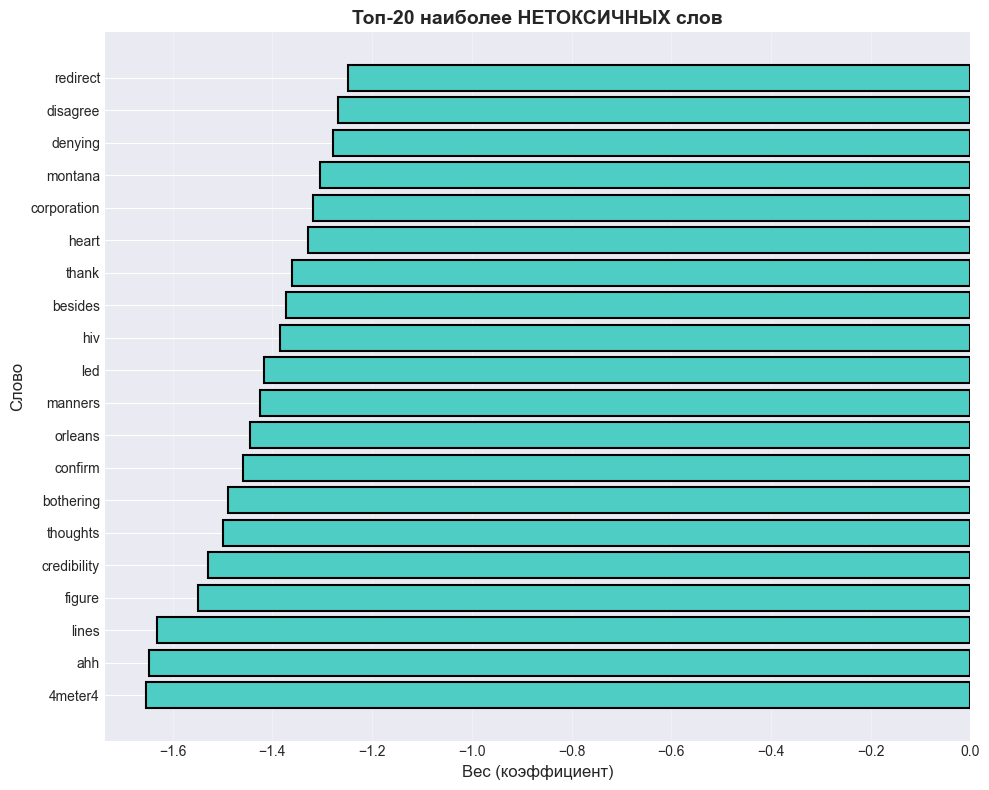

In [17]:
# Топ-20 нетоксичных слов
top_non_toxic = df_weights.nsmallest(20, 'weight')

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_non_toxic)), top_non_toxic['weight'].values, color='#4ECDC4', edgecolor='black', linewidth=1.5)
plt.yticks(range(len(top_non_toxic)), top_non_toxic['word'].values)
plt.xlabel('Вес (коэффициент)', fontsize=12)
plt.ylabel('Слово', fontsize=12)
plt.title('Топ-20 наиболее НЕТОКСИЧНЫХ слов', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### 7.4 Визуализация всех весов

Посмотрим на распределение весов для всех слов:


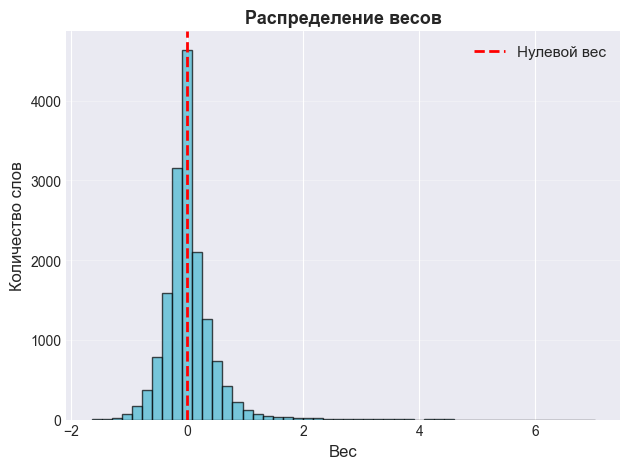

In [18]:
plt.hist(df_weights['weight'], bins=50, color='#45B7D1', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Нулевой вес')
plt.xlabel('Вес', fontsize=12)
plt.ylabel('Количество слов', fontsize=12)
plt.title('Распределение весов', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### 7.5 Интерпретация весов

**Что говорят нам веса:**

1. **Токсичные слова** (положительные веса) - часто это ненормативная лексика, оскорбления
2. **Нетоксичные слова** (отрицательные веса) - обычно вежливые фразы, благодарности, конструктивные слова
3. **Нейтральные слова** (веса близки к нулю) - не помогают в классификации

**Как модель принимает решение:**
$$
\text{Score} = \sum_{i} w_i \times x_i
$$

где $w_i$ - вес слова, $x_i$ - количество (или TF-IDF) слова в документе.

Если Score > 0 → комментарий токсичный, иначе → нетоксичный.


In [19]:
def predict(text: str) -> None:
    vectorized = count_vectorizer.transform([text])
    predicted = model_count.predict_proba(vectorized)
    logit = predicted[:, -1][0]
    prob = 1 / (1 + np.exp(-logit))
    print(f"Степень токсичности: {prob}")

In [20]:
print("3x hate")
predict("hate hate hate")

print("\n2x hate + thank")
predict("thank hate hate")
predict("hate thank hate")
predict("hate hate thank")

print("\nhate + 2x thank")
predict("thank thank hate")
predict("hate thank thank")

3x hate
Степень токсичности: 0.7273153901196082

2x hate + thank
Степень токсичности: 0.662397671047921
Степень токсичности: 0.662397671047921
Степень токсичности: 0.662397671047921

hate + 2x thank
Степень токсичности: 0.519062945578901
Степень токсичности: 0.519062945578901


## 8. Выводы

### Что мы узнали:

1. **Предобработка текста** - важный этап работы с текстовыми данными:
   - **Нормализация** приводит текст к единому виду
   - **Токенизация** разбивает текст на слова

2. **Векторизация** преобразует текст в числа:
   - **CountVectorizer** (векторизация подсчетом) - простой подсчет слов

3. **Логистическая регрессия** хорошо работает с текстом:
   - Быстрое обучение
   - Интерпретируемые результаты
   - Можно анализировать важность слов

4. **Анализ весов** позволяет понять логику модели:
   - Какие слова модель считает токсичными
   - Какие слова характерны для нетоксичных комментариев


### 🎯 Задания для самостоятельной работы:

1. **Попробуйте другие значения `min_df`** в векторизаторах. Как это влияет на качество?
2. **Используйте n-граммы** (`ngram_range=(1,2)` в векторизаторе). Улучшится ли качество?
3. **Проанализируйте ошибки модели**. Есть ли общие паттерны в неправильно классифицированных комментариях?
4. **Попробуйте другие модели**: Naive Bayes, SVM. Какая работает лучше?
5. **Создайте свои примеры** комментариев и проверьте, как их классифицирует модель.
6. **Изучите веса модели**. Какие слова вас удивили? Почему они получили такие веса?

### 📚 Полезные термины:

- **NLP (Natural Language Processing)** - обработка естественного языка
- **Токен** - единица текста (обычно слово)
- **Корпус** - набор документов
- **Sparse Matrix** - разреженная матрица (много нулей)
- **Feature** - признак (в нашем случае - слово)

---

**Поздравляем! Вы научились работать с текстовыми данными! 🎓**
